In [1]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime

#### time calculation

In [ ]:
import time
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))

In [2]:
db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')

In [3]:
cursor = db.cursor()

In [9]:
sql_statement = """ select count(*) as total
                    FROM [athena_dev].[dbo].[Taian]
                    where day(ENTRY_TIME) = 22 
                    and MVDIS_CATEGORY = 31
                    and DIRECTION_ID = 'N'
                    -- and STOP = 'P' ;
                """

In [10]:
output = cursor.execute(sql_statement).fetchall()

In [11]:

output[0][0]

21424

In [15]:
def sql_count_cars_amount(sa, day, category, direction, in_all):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()
    
    if in_all == 'in' :
        comment = ''
    elif in_all == 'all' :
        comment = '--'
    
    sql_statement = """ select count(*) as total
                        FROM [athena_dev].[dbo].[{0}]
                        where day(ENTRY_TIME) = {1}
                        and MVDIS_CATEGORY = {2}
                        and DIRECTION_ID = '{3}'
                        {4}and STOP = 'P' ;
                    """.format(sa, day, category, direction, comment)
    output = cursor.execute(sql_statement).fetchall()
    
    return output

In [17]:
sql_count_cars_amount("Taian", 23, 32, "N", "all")

[(8109, )]

In [174]:
df_state_amount_cars(sql_count_cars_amount, "Huko", days)

21                                              22                    \
       N                       S                       N                     
      in  total percentage    in  total percentage    in  total percentage   
31  3198  38321     8.35 %  2669  36627     7.29 %  3112  35238     8.83 %   
32  1243  11796    10.54 %  1036  11392     9.09 %  1269  11711    10.84 %   
41   238   2212    10.76 %   156   2233     6.99 %   272   2046    13.29 %   
42   484   4173     11.6 %   435   3821    11.38 %   635   4954    12.82 %   
5    302   3639      8.3 %   261   3341     7.81 %   379   4351     8.71 %   

            ...             26                              27         \
       S    ...              N      S                        N          
      in    ...     percentage     in  total percentage     in  total   
31  2743    ...        24.44 %  18341  55781    32.88 %  10188  55429   
32  1085    ...        24.57 %   4366  12846    33.99 %   2304  11536   
41   238    ...        28.25 %   1309   3681    35.56 %   1076   3549   
42   573    ...        19.97 %    478   1953    24.48 %    116    858   
5    376    ...        19.08 %    557   2130    26.15 %    129   1070   

                                       
                  S                    
   percentage    in  total percentage  
31    18.38 %  3857  50345     7.66 %  
32    19.97 %   812  10092     8.05 %  
41    30.32 %   416   3282    12.68 %  
42    13.52 %    78    965     8.08 %  
5     12.06 %    93   1161     8.01 %  

[5 rows x 42 columns]

In [29]:
import time
start_time = time.time()
days = [21, 22, 23, 24, 25, 26, 27]
df_state_amount_cars(sql_count_cars_amount, "Huko", days)
print("--- %s seconds ---" % (time.time() - start_time))

--- 26.923522233963013 seconds ---


#### #進入服務區車次統計 (與主線比較占比//分五車種)

In [20]:
def df_state_amount_cars(sql_count_cars_amount, sa, days):
    categories = [31, 32, 41, 42, 5]
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    list_31 = []
    list_32 = []
    list_41 = []
    list_42 = []
    list_5 = []
    
    for day in days :
        for category in categories :
            for direction in directions :    
                in_var = sql_count_cars_amount(sa, day, category, direction, "in")[0][0]
                cnt_var = sql_count_cars_amount(sa, day, category, direction, "all")[0][0]
                
                if cnt_var == 0 :
                    per_var = round(float(0), 2)
                else :
                    per_var = round(float((in_var/cnt_var)*100.0), 2)
                pecentage_var = "{0} %".format(per_var)
                
                if category == 31 :
                    list_31.append(in_var)
                    list_31.append(cnt_var)
                    list_31.append(pecentage_var)
                elif category == 32 :
                    list_32.append(in_var)
                    list_32.append(cnt_var)
                    list_32.append(pecentage_var)
                elif category == 41 :
                    list_41.append(in_var)
                    list_41.append(cnt_var)
                    list_41.append(pecentage_var)
                elif category == 42 :
                    list_42.append(in_var)
                    list_42.append(cnt_var)
                    list_42.append(pecentage_var)
                elif category == 5 :
                    list_5.append(in_var)
                    list_5.append(cnt_var)
                    list_5.append(pecentage_var)
    iterables = [days, directions, ['in', 'total', 'percentage']]
    col = pd.MultiIndex.from_product(iterables)
    final_df = pd.DataFrame([list_31, list_32, list_41, list_42, list_5], index=['31', '32', '41', '42', '5'], columns=col)
    # if needed a index_version dataframe, use transpose()
    
    return final_df

#### #進入服務區平均停留時間 (分五車種)

In [23]:
def sql_avg_cars_stD(sa, day, category, direction):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()
        
    sql_statement = """ select round(AVG(cast(STOP_DURATION as float)), 1) as avg_stD
                        FROM [athena_dev].[dbo].[{0}]
                        where day(ENTRY_TIME) = {1} 
                        and MVDIS_CATEGORY = {2}
                        and DIRECTION_ID = '{3}'
                        and STOP = 'P' ;
                    """.format(sa, day, category, direction)
    output = cursor.execute(sql_statement).fetchall()
    
    return output

In [26]:
def state_stDuration_cars(sql_avg_cars_stD, sa, days):
    categories = [31, 32, 41, 42, 5]
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    list_31 = []
    list_32 = []
    list_41 = []
    list_42 = []
    list_5 = []

    for day in days :
        for category in categories :
            for direction in directions :    
                in_var = sql_avg_cars_stD(sa, day, category, direction)[0][0]
                if category == 31 :
                    list_31.append(in_var)
                elif category == 32 :
                    list_32.append(in_var)
                elif category == 41 :
                    list_41.append(in_var)
                elif category == 42 :
                    list_42.append(in_var)
                elif category == 5 :
                    list_5.append(in_var)
    
    iterables = [days, directions]
    col = pd.MultiIndex.from_product(iterables)
    final_df = pd.DataFrame([list_31, list_32, list_41, list_42, list_5], index=['31', '32', '41', '42', '5'], columns=col)
    # if needed a index_version dataframe, use transpose()
    
    return final_df

In [27]:
state_stDuration_cars(sql_avg_cars_stD, "Taian", days)

21            22            23            24            25         \
        N      S      N      S      N      S      N      S      N      S   
31  24.51  23.24  23.91  23.94  23.86  23.19  24.36  23.46  24.54  20.92   
32  24.46  24.03  25.23  23.61  25.33  24.09  24.61  24.09  25.08  21.16   
41  23.03  25.68  20.57  27.24  23.16  21.34  22.43  24.33  23.01  18.30   
42  24.64  28.70  27.43  29.41  28.06  31.34  25.90  27.87  29.97  25.76   
5   22.71  31.49  23.59  31.87  23.94  31.68  24.49  36.04  22.81  26.93   

       26            27         
        N      S      N      S  
31  24.10  23.24  24.44  23.18  
32  25.05  23.49  24.80  24.01  
41  21.81  25.65  25.09  26.90  
42  26.44  27.27  25.44  28.32  
5   23.13  28.85  25.92  32.29

#### #進服務區與total進服務區佔主線比例 by 每日 by HOUR (total車種), NS分開擺

In [42]:
def sql_in_cars_byHour(sa, day, category, direction, in_all):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()
    
    if in_all == 'in' :
        comment = ''
    elif in_all == 'all' :
        comment = '--'
    
    # datepart(hour, ENTRY_TIME) as hour ,     
    sql_statement = """ select count(*) as total
                        FROM [athena_dev].[dbo].[{0}]
                        where day(ENTRY_TIME) = {1} 
                        and MVDIS_CATEGORY = {2}
                        and DIRECTION_ID = '{3}'
                        and STOP = 'P' 
                        group by datepart(hour, ENTRY_TIME)
                        order by datepart(hour, ENTRY_TIME) 
                    """.format(sa, day, category, direction)
    output = cursor.execute(sql_statement).fetchall()
    
    return output

In [49]:
#pd.DataFrame(sql_in_cars_byHour("Taian", 21, 31, "N"))#.reset_index()
test = pd.DataFrame([x[0] for x in sql_in_cars_byHour("Taian", 22, 31, "N")])#.reset_index()
#[x[0] for x in sql_in_cars_byHour("Taian", 22, 31, "N")]

In [50]:
test[0]

0      35
1      27
2      19
3      19
4      28
5      12
6      30
7      51
8      99
9     101
10    118
11    141
12    128
13    112
14    158
15    158
16    166
17    112
18    132
19     95
20     79
21     70
22     55
23     22
Name: 0, dtype: int64

#### method 1 : get out the value one by one...

#### can be divided by car types, will output 5 sheets (that will need to do the func 5 times)

In [171]:
def sql_in_cars_byHour_1(sa, day, category, direction, hour, in_all):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()
    
    if in_all == 'in' :
        comment = ''
    elif in_all == 'all' :
        comment = '--'
    
    if category == 'all' :
        cat_comment = '--'
    else :
        cat_comment = ''
    
    sql_statement = """ select count(*) as total
                        FROM [athena_dev].[dbo].[{0}]
                        where day(ENTRY_TIME) = {1} 
                        {6}and MVDIS_CATEGORY = {2}
                        and DIRECTION_ID = '{3}'
                        and datepart(hour, ENTRY_TIME) = {4}
                        {5}and STOP = 'P'
                        --group by datepart(hour, ENTRY_TIME)
                        --order by datepart(hour, ENTRY_TIME) 
                    """.format(sa, day, category, direction, hour, comment, cat_comment)
    output = cursor.execute(sql_statement).fetchall()
    
    return output

In [76]:
def state_amount_cars_byHOUR_1(sql_in_cars_byHour_1, sa, days, category):
    hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    categories = [31, 32, 41, 42, 5]
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    day_dfs = []
    day_dict = {}
    for direction in directions :
        total_list = []
        for hour in hours :
            dire_list = []
            #df_names = ["day_df_%s"%x for x in range(9)]
            for day in days :
                cnt_var = sql_in_cars_byHour_1(sa, day, category, direction, hour, "all")[0][0]
                in_var = sql_in_cars_byHour_1(sa, day, category, direction, hour, "in")[0][0]
                #out_var = df[(df.STOP == 'T')&(df.ENTRY_TIME.dt.day == day)&(df.ENTRY_TIME.dt.hour == hour)&(df.DIRECTION_ID == dire)].shape[0]
                if cnt_var == 0 :
                    per_var = round(float(0), 2)
                else :
                    per_var = round(float((in_var/cnt_var)*100.0), 2)
                
                #per_var = round(float((in_var/cnt_var)*100.0), 2) => cause error by "division by zero"(cnt_var=0)
                pecentage_var = "{0} %".format(per_var)
                dire_list.append(in_var)
                dire_list.append(cnt_var)
                dire_list.append(pecentage_var)
            total_list.append(dire_list)
        iterables = [[direction], days, ['in', 'total', 'percentage']]
        col = pd.MultiIndex.from_product(iterables)
        
        
        day_dict['direct_df_%s'%direction] = pd.DataFrame(total_list, index=hours, columns=col)
        
        day_dfs.append(day_dict['direct_df_%s'%direction])
        
    result_df = pd.concat(day_dfs, axis=1) 
    
    return result_df

In [172]:
start_time = time.time()
tt = state_amount_cars_byHOUR_1(sql_in_cars_byHour_1, "Taian", days, 'all')
print("--- %s seconds ---" % (time.time() - start_time))

--- 66.2917127609253 seconds ---


#### #各時段進入車輛數vs停留時間(by 10 minute), divided NS

In [183]:
def sql_in_stD_cars_by10minutes(sa, day, category, direction, hour, start_min, end_min):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    # datepart(hour, ENTRY_TIME) as hour ,     
    sql_statement = """ select count(*) as min_cnt , round(avg(cast(STOP_DURATION as float)), 2) as min_stD
                        FROM [athena_dev].[dbo].[{0}]                        
                        where STOP = 'P'
                        and day(ENTRY_TIME) = {1}
                        and MVDIS_CATEGORY = {2}
                        and DIRECTION_ID = '{3}'
                        and datepart(hour, ENTRY_TIME) = {4}
                        and DATEPART(MINUTE, ENTRY_TIME) >= {5}
                        and DATEPART(MINUTE, ENTRY_TIME) <= {6}
                        
                    """.format(sa, day, category, direction, hour, start_min, end_min)
    output = cursor.execute(sql_statement).fetchall()
    
    return output

In [185]:
sql_in_stD_cars_by10minutes("Huko", 21, 31, "N", 0, 0, 11)[0][1]

77.15

In [94]:
start_min = [00, 11, 21, 31, 41, 51]
end_min = [10, 20, 30, 40, 50, 59]
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
col_min = []
for i in hours:
    for j in enumerate(start_min):
        string = "{0}:{1}-{0}:{2}".format(i, j[1], end_min[j[0]])
        col_min.append(string)
        #print(string)

#### THIS IS A HARDCORE WAY.... IT'LL TAKE TIMESSSSSSS

In [184]:
def cars_amount_stD_Day_NS(sql_in_stD_cars_by10minutes, sa, days, category) :
    day_dfs = []
    day_dict = {}
    
    categories = [31, 32, 41, 42, 5]
    hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    start_min = [0, 11, 21, 31, 41, 51]
    end_min = [10, 20, 30, 40, 50, 59]
    #directions = ['N', 'S']
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
        
    
    for direction in directions : 
        total_list = []
        
        for hour in hours :
            
            for num in enumerate(start_min):
                dire_list = []
                for day in days :

                    #cnt_var = df[(df.ENTRY_TIME.dt.day == day)& (df["STOP"] == 'P')  &(df.DIRECTION_ID == direction)& (df.MVDIS_CATEGORY == category) & (df.ENTRY_TIME.dt.hour == hour) & (df.ENTRY_TIME.dt.minute >= num[1]) & (df.ENTRY_TIME.dt.minute <= end_min[num[0]])].shape[0]
                    #stD_var = df[(df.ENTRY_TIME.dt.day == day)& (df["STOP"] == 'P')  &(df.DIRECTION_ID == direction)& (df.MVDIS_CATEGORY == category) & (df.ENTRY_TIME.dt.hour == hour) & (df.ENTRY_TIME.dt.minute >= num[1]) & (df.ENTRY_TIME.dt.minute <= end_min[num[0]])]['STOP_DURATION'].mean()
                    
                    cnt_var = sql_in_stD_cars_by10minutes(sa, day, category, direction, hour, num[1], end_min[num[0]])[0][0]
                    stD_var = sql_in_stD_cars_by10minutes(sa, day, category, direction, hour, num[1], end_min[num[0]])[0][1]

                    #r_stD_var = round(stD_var, 2)

                    dire_list.append(cnt_var)
                    dire_list.append(stD_var)

                total_list.append(dire_list)
        iterables = [[direction], days, ['in', 'stop_duration']]
        col = pd.MultiIndex.from_product(iterables)
        
        
        day_dict['direct_df_%s'%direction] = pd.DataFrame(total_list, index=col_min, columns=col)
        
        day_dfs.append(day_dict['direct_df_%s'%direction])
        
    result_df = pd.concat(day_dfs, axis=1) 
    
    return result_df

In [188]:

start_time = time.time()
cnt_df = cars_amount_stD_Day_NS(sql_in_stD_cars_by10minutes, "Huko", days, 31)
print("--- %s seconds ---" % (time.time() - start_time))

--- 675.7029774188995 seconds ---


In [189]:
cnt_df

N                                                         \
             21                22                23                 24   
             in stop_duration  in stop_duration  in stop_duration   in   
0:0-0:10     26         78.27  10         35.10   8        261.88   35   
0:11-0:20    21         63.81   8        187.38   7         85.43   12   
0:21-0:30    20         58.70   8        178.25   1        125.00    5   
0:31-0:40    17        108.76   5        247.40   2         26.00    3   
0:41-0:50     9         82.56   2        179.00   6        200.50    4   
0:51-0:59     4         35.75   3         39.67   2         39.00    6   
1:0-1:10     11        147.64   7        162.00   4        143.00    6   
1:11-1:20     5         91.60   2         97.00   4         25.75    3   
1:21-1:30     2        287.50   1         52.00   2         22.50    1   
1:31-1:40     8         74.50   3         21.33   6        109.00    4   
1:41-1:50     7        138.86   2        536.00   5         26.80    3   
1:51-1:59     8         31.63   2        137.00   2        454.50    3   
2:0-2:10      1         24.00   6        389.67   3        109.67    3   
2:11-2:20     2         55.50   2         33.50   3         71.33    3   
2:21-2:30     7         96.29   4         22.50   1         47.00    4   
2:31-2:40     1         28.00   5        253.00   2         16.00    4   
2:41-2:50     5         39.60   5         28.60   1         34.00    1   
2:51-2:59     3        103.33   4         23.25   2        286.50    2   
3:0-3:10      4        308.25   4         65.75   6        183.00    1   
3:11-3:20     8         49.38   4         50.25   5         54.20    2   
3:21-3:30     9         51.89   3         88.33   2         26.00    3   
3:31-3:40     2        590.50   6         27.50   2         19.50    4   
3:41-3:50     3         31.67   6         45.83   3         24.67    5   
3:51-3:59     3        114.67   2         24.50   3         23.67    3   
4:0-4:10      1        112.00   2         17.50   4         18.50    2   
4:11-4:20     4         25.00   1        239.00   4        103.00    5   
4:21-4:30     4        150.25   2         31.50   3        131.67    0   
4:31-4:40     4         34.00   8         51.00   4         63.50    3   
4:41-4:50     3         49.33   3         21.67   5         47.40    2   
4:51-4:59     4         64.75   3         28.33   2         19.50    9   
...          ..           ...  ..           ...  ..           ...  ...   
19:0-19:10   27         37.96  27         57.19  23         49.52   27   
19:11-19:20  27         33.33  12         31.83  26         28.85   29   
19:21-19:30  14         30.71  17         40.00  30         39.43   33   
19:31-19:40  13         43.62  23         39.57  25         36.12   30   
19:41-19:50  27         38.00  13         30.08  25         40.44   27   
19:51-19:59  21         35.29  30         32.87  21         35.19   23   
20:0-20:10   24         30.54  28         27.54  28         41.71   18   
20:11-20:20  16         38.13  14         37.14  18         30.72   18   
20:21-20:30  30         37.10  19         34.58  20         32.40  209   
20:31-20:40  18         31.17  19         35.84  21         28.90  282   
20:41-20:50  21         21.76  18         32.28  19         30.42  185   
20:51-20:59  15         32.20  13         32.46  11         35.64  117   
21:0-21:10   16         28.56  24         25.17  29         34.90  180   
21:11-21:20  16         25.31  24         34.21  18         26.33  166   
21:21-21:30   8         20.88  18         36.39  15         32.93  181   
21:31-21:40   9         24.67  19         29.74  15         28.60   16   
21:41-21:50  17         30.24  35         21.63   8         23.00   10   
21:51-21:59  10         22.20  38         19.58  17         27.82    8   
22:0-22:10   12         39.25  12         30.42  13         27.46   18   
22:11-22:20  11         22.64  11         28.45  12         33.83   10   
22:21-22:30  15   

#### #進入服務區_性別比 for each SA, everyday, 分車種, adding(df.STOP == 'P'), 各車輛

In [125]:
def sql_FMF_car_table(sa):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    # datepart(hour, ENTRY_TIME) as hour ,     
    sql_statement = """ 
                        EXECUTE GetFMFGroupResult {0}
                    """.format(sa)
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("---query time : %s seconds ---" % (time.time() - start_time))
    
    return output

In [124]:
def M_FM_percentage_CAR(sql_FMF_car_table, sa, days):
    categories = [31, 32, 41, 42, 5]
    # getting the SQL result
    sql_result_list = sql_FMF_car_table(sa) 
    # make the result list into a dataframe in order to make easy queries
    result_list = []
    for each in sql_result_list :
        each = list(each)
        result_list.append(each)
    sql_df = pd.DataFrame(result_list, columns = ['ENTRY_DAY', 'CATEGORY', 'DIRECTION', 'MALE', 'MALE_CNT', 'FEMALE', 'FEMALE_CNT', 'NON', 'NON_CNT']).fillna(0)
    # define sa's directions
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    # do quries by loop
    total_list = [] # this is the ending dataframe list
    for day in days :
        record = [] # this is the list for each row
        for direction in directions :
            for category in categories:
                result_M = list(sql_df[(sql_df.ENTRY_DAY == day)&(sql_df.DIRECTION == direction)&(sql_df.CATEGORY == category)]['MALE_CNT'])[0]
                result_F = list(sql_df[(sql_df.ENTRY_DAY == day)&(sql_df.DIRECTION == direction)&(sql_df.CATEGORY == category)]['FEMALE_CNT'])[0]
                result_N = list(sql_df[(sql_df.ENTRY_DAY == day)&(sql_df.DIRECTION == direction)&(sql_df.CATEGORY == category)]['NON_CNT'])[0]
                record.append(result_M)
                record.append(result_F)
                record.append(result_N)
        total_list.append(record)
    iterables = [directions, ['31', '32', '41', '42', '5'], ['Female', 'Male', 'Non']]
    col = pd.MultiIndex.from_product(iterables)
    
    result_df = pd.DataFrame(total_list, index=days, columns=col)   
    return result_df

In [126]:
start_time = time.time()
fmf_df = M_FM_percentage_CAR(sql_FMF_car_table, "Huko", days)
print("---function process : %s seconds ---" % (time.time() - start_time))

---query time : 9.1134033203125 seconds ---
---function process : 9.39803171157837 seconds ---


#### #進入服務區車_車廠(各SA), 車輛

In [142]:
def sql_sorting_CarBrand(sa, day, category, direction) :
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    if category == 'all' :
        
        sql_statement = """ 
                            EXECUTE GetCarBrandGroupResult_Total {0}, {1}, {2}
                        """.format(sa, day, direction)
    else :
        
        sql_statement = """ 
                            EXECUTE GetCarBrandGroupResult {0} ,{1}, {2}, {3} 
                        """.format(sa, day, category, direction)
        
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("---query time : %s seconds ---" % (time.time() - start_time))
    
    return output

In [144]:
def sql_result_to_list(sql_result_list, columns) :
    # make the result list into a dataframe in order to make easy queries
    result_list = []
    for each in sql_result_list :
        each = list(each)
        result_list.append(each)
    sql_df = pd.DataFrame(result_list, columns = columns).fillna(0)
    return sql_df

In [169]:
def stat_car_brand_eachSA_CAR(sql_sorting_CarBrand, sql_result_to_list, sa, days) :
    categories = [31, 32, 41, 42, 5]
    # define sa's directions
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    directions_dfs = []
    # using loop to get each sql result
    for direction in directions :
        group_dict = {}
        cat_dfs = []
        for day in days :
            
            for category in categories :
                # getting the SQL result
                sql_result_list = sql_sorting_CarBrand(sa, day, category, direction)
                # make the result list into a dataframe in order to make easy queries
                sql_df = sql_result_to_list(sql_result_list, ['BRAND', 'COUNT'])
                                
                group_dict['{0}_{1}'.format(day, category)] = sql_df
                cat_dfs.append(group_dict['{0}_{1}'.format(day, category)])
            # for total car types grouping
            TotalType_result = sql_sorting_CarBrand(sa, day, 'all', direction)
            TotalType_df = sql_result_to_list(TotalType_result, ['BRAND', 'COUNT'])
            group_dict['{0}_total'.format(day)] = TotalType_df
            cat_dfs.append(group_dict['{0}_total'.format(day)])
        days_df = pd.concat(cat_dfs, axis=1)
        directions_dfs.append(days_df)
    iterables = [directions, days, ['31', '32', '41', '42', '5', 'total'], ['BRAND', 'car_num']]
    col = pd.MultiIndex.from_product(iterables)
        
    result_df = pd.concat(directions_dfs, axis=1)
    result_df.columns = col
    
    return result_df

In [150]:
start_time = time.time()
brand_df = stat_car_brand_eachSA_CAR(sql_sorting_CarBrand, "Taian", days)
print("---function process : %s seconds ---" % (time.time() - start_time))

---query time : 0.17130017280578613 seconds ---
---query time : 0.10938382148742676 seconds ---
---query time : 0.08855509757995605 seconds ---
---query time : 0.08913064002990723 seconds ---
---query time : 0.09373331069946289 seconds ---
---query time : 0.16952896118164062 seconds ---
---query time : 0.15854477882385254 seconds ---
---query time : 0.11532831192016602 seconds ---
---query time : 0.09127116203308105 seconds ---
---query time : 0.09457921981811523 seconds ---
---query time : 0.09048962593078613 seconds ---
---query time : 0.1704545021057129 seconds ---
---query time : 0.14717745780944824 seconds ---
---query time : 0.10236239433288574 seconds ---
---query time : 0.09242844581604004 seconds ---
---query time : 0.09227204322814941 seconds ---
---query time : 0.09023904800415039 seconds ---
---query time : 0.17243051528930664 seconds ---
---query time : 0.14823126792907715 seconds ---
---query time : 0.1250591278076172 seconds ---
---query time : 0.0781400203704834 seconds

#### #進入服務區車於觀察區間的表現(for one SA) FIXED

In [153]:
def sql_behavioral_state(sa, category, direction):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    sql_statement = '''
                        EXECUTE GetCarBehaviorResult {0} ,{1}, {2}
                    '''.format(sa, category, direction)
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("---query time : %s seconds ---" % (time.time() - start_time))
    
    return output

In [158]:
sql_result_to_list(sql_behavioral_state("Taian", 31, "S"), ['cnt', 'wd_avg', 'wk_avg'])['cnt'][0]
#sql_behavioral_state("Taian", 31, "S")

---query time : 0.34051942825317383 seconds ---


27928

In [167]:
def behavioral_state(sql_behavioral_state, sql_result_to_list, sa) :
    categories = [31, 32, 41, 42, 5]
    wk_wd = ['WEEKDAY_CNT', 'Holiday_cnt']
    # define sa's directions
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
        
    total_dfs = {}
    dfs = []
    
    for direction in directions :
        dire_list = []
        
        for category in categories:
            list_type = []
            sql_result = sql_behavioral_state(sa, category, direction)
            sql_df = sql_result_to_list(sql_result, ['cnt', 'wd_avg', 'wk_avg'])
    
            total_var = round(sql_df['cnt'][0], 0)
            r_total_var = int(total_var)
            wd_var = sql_df['wd_avg'][0]
            wk_var = sql_df['wk_avg'][0]
            
            list_type.append(r_total_var)
            list_type.append(wd_var)
            list_type.append(wk_var)
            
            dire_list.append(list_type)
        dire_df = pd.DataFrame(dire_list, index = categories)
        total_dfs["{0}_df".format(direction)] = dire_df
        dfs.append(total_dfs["{0}_df".format(direction)])
    iterables = [directions, ['car_cnt', 'weekday_avg', 'weekend_avg']]
    col = pd.MultiIndex.from_product(iterables)
    result_df = pd.concat(dfs, axis=1)
    result_df.columns = col
    result_df = result_df.transpose()
    
    return result_df

In [168]:
behavioral_state(sql_behavioral_state, sql_result_to_list, 'Taian')

---query time : 0.33645105361938477 seconds ---
---query time : 0.1562345027923584 seconds ---
---query time : 0.09583783149719238 seconds ---
---query time : 0.09379291534423828 seconds ---
---query time : 0.09376192092895508 seconds ---
---query time : 0.3427412509918213 seconds ---
---query time : 0.15626072883605957 seconds ---
---query time : 0.09529638290405273 seconds ---
---query time : 0.09376072883605957 seconds ---
---query time : 0.09378194808959961 seconds ---


31       32       41       42       5 
N car_cnt      20393.00  5606.00  1422.00  1386.00  1015.00
  weekday_avg     30.92    36.86    58.26    74.93    85.91
  weekend_avg     16.23    13.96    30.24    12.93    25.07
S car_cnt      27928.00  7579.00  1654.00  1463.00   443.00
  weekday_avg     31.07    36.53    61.27    74.79    81.50
  weekend_avg     15.93    13.80    31.07    12.08    19.32

#### for drawing 

In [ ]:
sql_count_cars_amount(sa, day, category, direction, in_all)

In [191]:
def state_amount_cars_sty2(sql_count_cars_amount, sa, days):
    total_list = []
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']
    
    
    for direction in directions :
        dire_dict = {}
        dire_dict['{0}_in'.format(direction)] = []
        dire_dict['{0}_total'.format(direction)] = []
        dire_dict['{0}_percentage'.format(direction)] = []
        
        for day in days :

            for category in categories :    

                cnt_var = sql_count_cars_amount(sa, day, category, direction, 'all')[0][0]
                in_var = sql_count_cars_amount(sa, day, category, direction, 'in')[0][0]
                if cnt_var == 0 :
                    per_var = round(float(0), 2)
                else :
                    per_var = round(float((in_var/cnt_var)*100.0), 2)
                
                dire_dict['{0}_in'.format(direction)].append(in_var)
                dire_dict['{0}_total'.format(direction)].append(cnt_var)
                dire_dict['{0}_percentage'.format(direction)].append(per_var)
        total_list.append(dire_dict['{0}_in'.format(direction)])   
        total_list.append(dire_dict['{0}_total'.format(direction)])
        total_list.append(dire_dict['{0}_percentage'.format(direction)])
                  
    iterables_col = [days, ['31', '32', '41', '42', '5']]
    column = pd.MultiIndex.from_product(iterables_col)
    iterables_index = [directions, ['in', 'total', 'percentage']]
    index = pd.MultiIndex.from_product(iterables_index)
    
    final_df = pd.DataFrame(total_list, index=index, columns=column)
    # if needed a index_version dataframe, use transpose()
    
    return final_df

In [225]:
sql_count_cars_amount("Huko", 26, 32, "N", 'in')[0][0]

2790

In [255]:
def draw_cars_amount(X, df, stD_df, direction, SA_name, file_name):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # X = ['12', '13', '14', '15', '16', '17', '18']
    # setting the variable first
    categories = [31, 32, 41, 42, 5]
    variables = {}
    
    fig, ax1 = plt.subplots(1,1,figsize=(8, 5))
    ax2 = ax1.twinx()
    
    N=7
    bottom = np.zeros(N)
    
    for ind, i in enumerate(categories) :
        data = []
        if direction == 'N' :
            variables["N_in_{0}".format(i)] = np.array([list(df.iloc[0, :])[x] for x in [i for i in range(ind, 35, 5)]])
            #variables["N_{0}_stD".format(i)] = np.array([stD_df.iloc[ind, :][x] for x in [i for i in range(0, 14, 2)]])
            data.append(variables["N_in_{0}".format(i)])
            
            for elem in data:
                ax1.bar(X, variables["N_in_{0}".format(i)], label='{0}_{1}'.format(i, direction), alpha = 0.4, bottom = bottom)
                bottom += elem
            if len(directions) == 1 :
                ax2.plot(X,stD_df.iloc[ind, :], label='{0}_{1}'.format(i, direction))
            else :
                variables["N_{0}_stD".format(i)] = np.array([list(stD_df.iloc[ind, :])[x] for x in [i for i in range(0, 14, 2)]])
                ax2.plot(X,variables["N_{0}_stD".format(i)], label='{0}_{1}'.format(i, direction))
            
        elif direction == 'S' :
            variables["S_in_{0}".format(i)] = np.array([list(df.iloc[3, :])[x] for x in [i for i in range(ind, 35, 5)]])
            #variables["S_{0}_stD".format(i)] = [stD_df.iloc[ind, :][x] for x in [i for i in range(1, 14, 2)]]
            data.append(variables["S_in_{0}".format(i)])
            
            for elem in data:
                ax1.bar(X, variables["S_in_{0}".format(i)], label='{0}_{1}'.format(i, direction), alpha = 0.4, bottom = bottom)
                bottom += elem
            #ax2.plot(X,stD_df, label='{0}_{1}'.format(i, direction))
            if len(directions) == 1 :
                ax2.plot(X,stD_df.iloc[ind, :], label='{0}_{1}'.format(i, direction))
            else :
                variables["S_{0}_stD".format(i)] = np.array([list(stD_df.iloc[ind, :])[x] for x in [i for i in range(1, 14, 2)]])
                ax2.plot(X,variables["S_{0}_stD".format(i)], label='{0}_{1}'.format(i, direction))
    
    ax1.set_ylabel('amount of cars')
    ax1.set_xlabel('date in May')
    lgd1 = ax1.legend(bbox_to_anchor=(1.25, 1))
    lgd2 = ax2.legend(bbox_to_anchor=(1.25, 0.5))
    #ax2.set_ylim(15, 40)
    ax2.set_ylabel('average stop duration (minutes)')
    ax2.set_xlabel('date in March')


    plt.grid()
    plt.title('Stopped numbers of cars with stop_durations in {0} direction {1}'.format(SA_name, direction))
    plt.show()

    fig.savefig('C://Users//AthenaLee//Documents//code//graph//{2}//{1}_{0}.png'.format(direction, file_name, SA_name), bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

In [180]:
def drawing_stD_cnt_10min_batch(df_dict, days, col_min, SA_name) :
    import matplotlib.pyplot as plt
    import numpy as np
    
    XX = col_min
    hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    categories = ['31', '32', '41', '42', '5']
    #fig, ax1 = plt.subplots(1,1,figsize=(16, 5))
    #variables = {}
    #N=144
    #bottom = np.zeros(N)
    #ax2 = ax1.twinx()
    
    for day in days :
        for dire in directions :
            fig, ax1 = plt.subplots(1,1,figsize=(16, 5))
            variables = {}
            N=144
            bottom = np.zeros(N)
            ax2 = ax1.twinx()
            for category in categories :
            
                #df_dict["{0}_min_df".format(category)][dire][day]["in"]
                
                data = []
                variables["{1}_in_{0}".format(category, dire)] = np.array(df_dict["{0}_min_df".format(category)][dire][day]["in"])
                #variables["{1}_{0}_stD".format(category, dire)] = np.array(df_dict["{0}_min_df".format(category)][dire][day]["stop_duration"])
                data.append(variables["{1}_in_{0}".format(category, dire)])

                for elem in data:
                    ax1.bar(XX, variables["{1}_in_{0}".format(category, dire)], label='{0}_{1}'.format(category, dire), alpha = 0.4, bottom = bottom)
                    bottom += elem

                df_dict["{0}_min_df".format(category)][dire][day]["stop_duration"].fillna(0).plot(linewidth = 1.2, label='{0}_{1}_stD'.format(category, dire))
                #ax2.plot(XX,variables["{1}_{0}_stD".format(cat, direction)], label='{0}_{1}_stD'.format(cat, direction))
    
            label = []
            for hour in hours:
                xticks_label = "{0}:00".format(hour)
                label.append(xticks_label)

            ax1.set_xticks([col_min[i] for i in range(0, 144, 6)])
            ax1.set_xticklabels(label)


            ax1.set_ylabel('amount of cars')
            ax1.set_xlabel('duration of minutes')


            #plt.xticks(rotation=90)
            lgd1 = ax1.legend(bbox_to_anchor=(1.15, 1))

            lgd2 = ax2.legend(bbox_to_anchor=(1.15, 0.5))
            #ax2.set_ylim(15, 30)
            ax2.set_ylabel('average stop duration (minutes)')
            ax2.set_xlabel('minutes duration')


            ax2.margins(0.015625)    
            #ax2.set_xticks(['0:0-0:10', '1:0-1:10'])
            #ax2.set_xticklabels(['0:00', '1:00'])

            plt.grid()
            plt.title('Stopped numbers of cars with stop duration in {0} {1} {2}'.format(SA_name, day, dire))
            plt.tight_layout()
            plt.show()

            fig.savefig('C://Users//AthenaLee//Documents//code//graph//{0}//{1}_{2}_stD_cnt.png'.format(SA_name, day, dire), bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

In [ ]:
df_state_amount_cars(sql_count_cars_amount, sa, days)
state_stDuration_cars(sql_avg_cars_stD, sa, days)
state_amount_cars_byHOUR_1(sql_in_cars_byHour_1, sa, days, category)
cars_amount_stD_Day_NS(sql_in_stD_cars_by10minutes, sa, days, category) # huko, guanxi only
M_FM_percentage_CAR(sql_FMF_car_table, sa, days)
stat_car_brand_eachSA_CAR(sql_sorting_CarBrand, sql_result_to_list, sa, days)
behavioral_state(sql_behavioral_state, sql_result_to_list, sa)

done Guanxi amount
done Guanxi HOUR amount
done Guanxi stD
---query time : 3.5975446701049805 seconds ---
done Guanxi FMF
---query time : 0.17483115196228027 seconds ---
---query time : 0.10938739776611328 seconds ---
---query time : 0.07813405990600586 seconds ---
---query time : 0.09375810623168945 seconds ---
---query time : 0.10757946968078613 seconds ---
---query time : 0.21356701850891113 seconds ---
---query time : 0.18449044227600098 seconds ---
---query time : 0.12165331840515137 seconds ---
---query time : 0.0837399959564209 seconds ---
---query time : 0.09375834465026855 seconds ---
---query time : 0.09376072883605957 seconds ---
---query time : 0.1808452606201172 seconds ---
---query time : 0.1705470085144043 seconds ---
---query time : 0.12384629249572754 seconds ---
---query time : 0.07732629776000977 seconds ---
---query time : 0.10325241088867188 seconds ---
---query time : 0.09154319763183594 seconds ---
---query time : 0.17383551597595215 seconds ---
---query time : 0

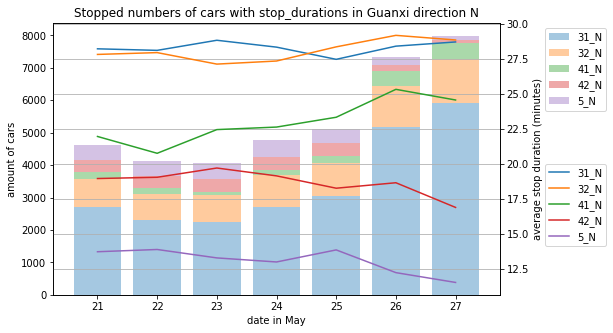

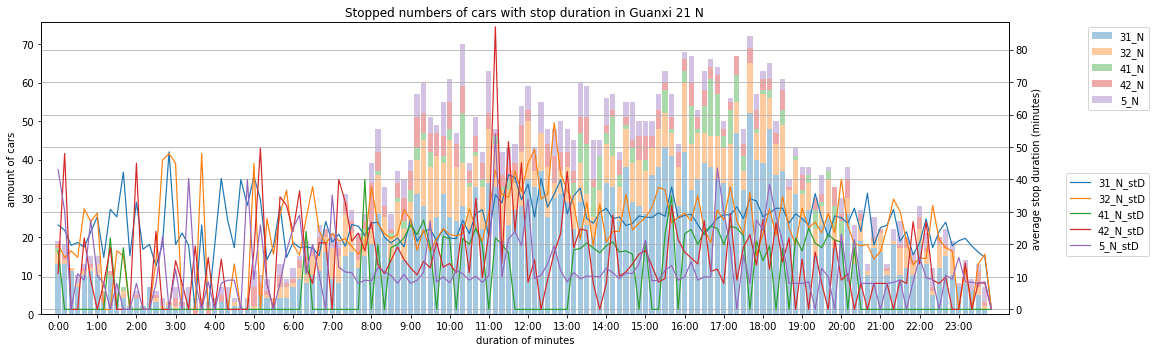

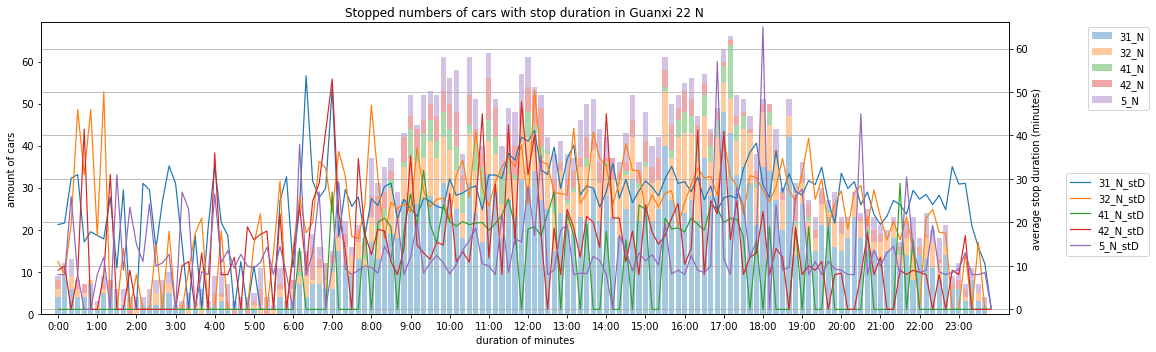

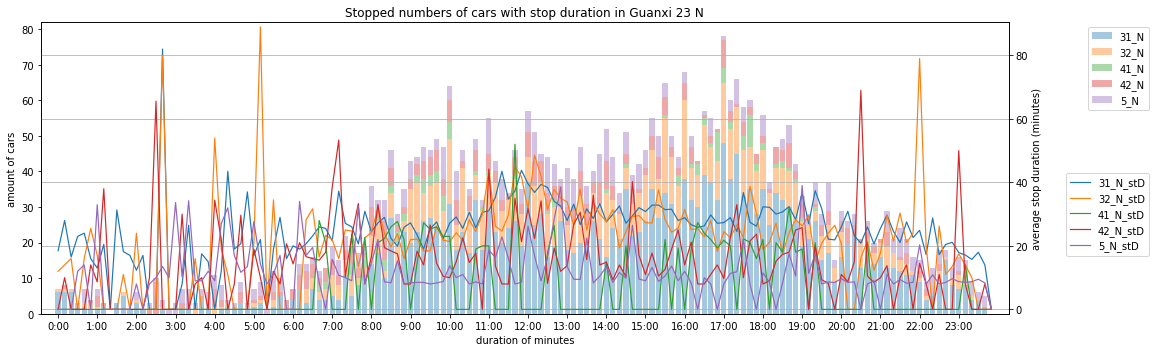

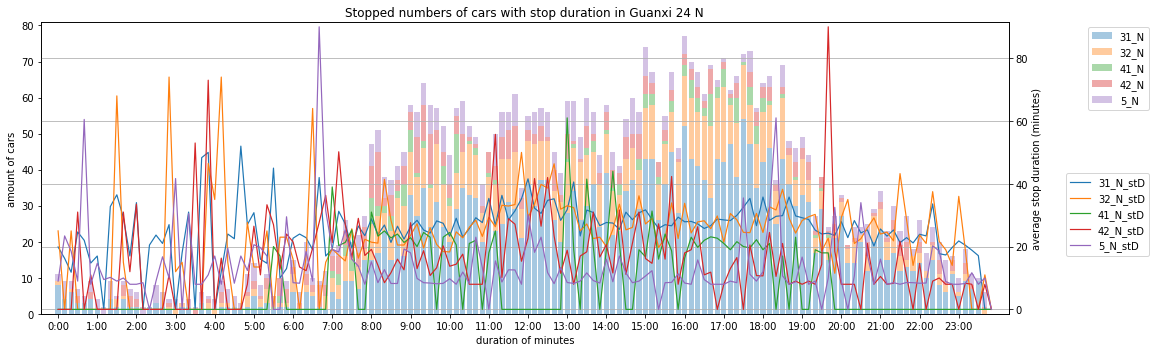

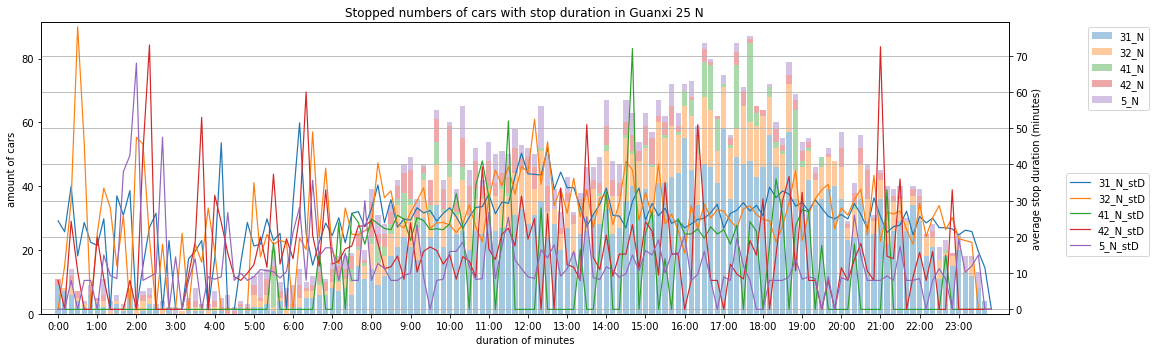

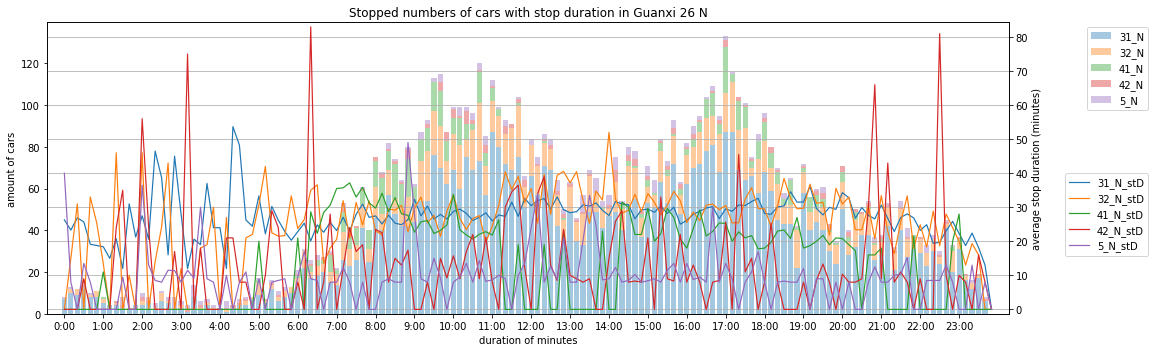

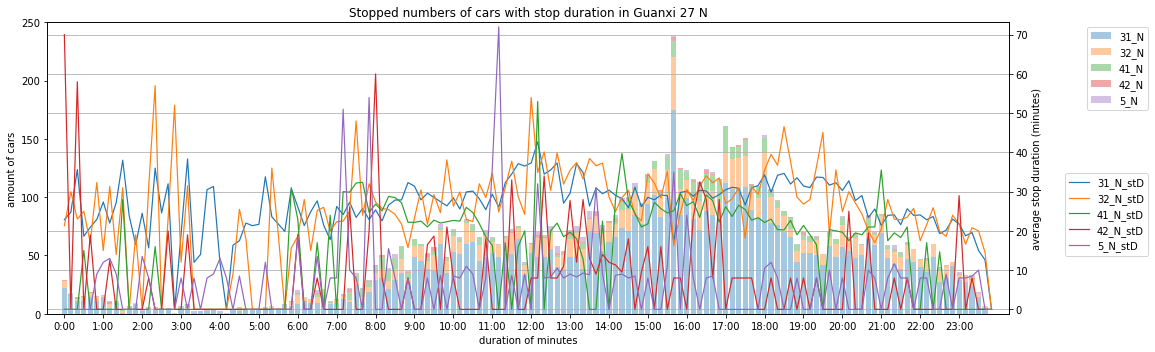

In [258]:
SA_name = ["Guanxi"]
categories = [31, 32, 41, 42, 5]
for sa in SA_name :
    df_stDcnt_dict = {}
    if (sa == "Xilou") or (sa == "Guanxi") :
        directions = ["N"]
    else :
        directions = ['N', 'S']

    report_dict["df_{0}".format(sa)] = df_state_amount_cars(sql_count_cars_amount, sa, days)
    print('done {0} amount'.format(sa))
    report_dict["df_{0}_HOUR_T_NS".format(sa)] = state_amount_cars_byHOUR_1(sql_in_cars_byHour_1, sa, days, "all")
    print('done {0} HOUR amount'.format(sa))
    report_dict["df_{0}_stD".format(sa)] = state_stDuration_cars(sql_avg_cars_stD, sa, days)
    print('done {0} stD'.format(sa))
    
    report_dict["df_{0}_FMF_df".format(sa)] = M_FM_percentage_CAR(sql_FMF_car_table, sa, days)
    print('done {0} FMF'.format(sa))
    report_dict["df_{0}_total_brand_sorting".format(sa)] = stat_car_brand_eachSA_CAR(sql_sorting_CarBrand, sql_result_to_list, sa, days)
    print('done {0} brand_sorting'.format(sa))
    report_dict["df_{0}_behave_df".format(sa)] = behavioral_state(sql_behavioral_state, sql_result_to_list, sa)
    print('done {0} behave'.format(sa))
    
    for category in categories :
        report_dict["df_{0}_HOUR_{1}_NS".format(sa, category)] = state_amount_cars_byHOUR_1(sql_in_cars_byHour_1, sa, days, category)
        print('done {0} {1} HOUR amount'.format(sa, category))
        report_dict["df_{0}_stDcnt_{1}_NS".format(sa, category)] = cars_amount_stD_Day_NS(sql_in_stD_cars_by10minutes, sa, days, category)
        print('done {0} {1} 10min stDcnt'.format(sa, category))
        df_stDcnt_dict["{0}_min_df".format(category)] = report_dict["df_{0}_stDcnt_{1}_NS".format(sa, category)]
    
    writer = pd.ExcelWriter('C://Users//AthenaLee//Documents//code//data//data_SA//analysis_result//{0}.xlsx'.format(sa))
    report_dict["df_{0}".format(sa)].to_excel(writer,'AmountOfCarsIntoSA')
    report_dict["df_{0}_HOUR_T_NS".format(sa)].to_excel(writer,'byHOUR_AmountOfCarsIntoSA')
    for category in categories :
        report_dict["df_{0}_HOUR_{1}_NS".format(sa, category)].to_excel(writer,'byHOUR_{0}_AmountOfCarsIntoSA'.format(category))
        report_dict["df_{0}_stDcnt_{1}_NS".format(sa, category)].to_excel(writer,'{0}_stD_cnt'.format(category))
    
    report_dict["df_{0}_stD".format(sa)].to_excel(writer,'StopDurationIntoSA') 
    
    report_dict["df_{0}_FMF_df".format(sa)].to_excel(writer,'gender_everyday') 
    report_dict["df_{0}_total_brand_sorting".format(sa)].to_excel(writer,'brand_sorting') 
    report_dict["df_{0}_behave_df".format(sa)].to_excel(writer,'behavioral_state') 
    writer.save()
    print('done {0} file saved !'.format(sa))
    # drawing session
    report_dict["df_{0}_stD_forDraw".format(sa)] = state_amount_cars_sty2(sql_count_cars_amount, sa, days)
    for dire in directions :
        draw_cars_amount(days, report_dict["df_{0}_stD_forDraw".format(sa)], report_dict["df_{0}_stD".format(sa)], dire, sa, "0521_0527")
    drawing_stD_cnt_10min_batch(df_stDcnt_dict, days, col_min, sa)

In [170]:
SA_name = ["Taian", "Zhongli", "Xihu", "Xilou", "Nantou", "QingShui", "Huko", "Guanxi"]
days = [21, 22, 23, 24, 25, 26, 27]
report_dict = {}
for sa in SA_name :
    report_dict["df_{0}_FMF_df".format(sa)] = M_FM_percentage_CAR(sql_FMF_car_table, sa, days)
    print('done FMF {0}'.format(sa))
    report_dict["df_{0}_total_brand_sorting".format(sa)] = stat_car_brand_eachSA_CAR(sql_sorting_CarBrand, sql_result_to_list, sa, days)
    print('done brand {0}'.format(sa))
    report_dict["df_{0}_behave_taian_df".format(sa)] = behavioral_state(sql_behavioral_state, sql_result_to_list, sa)
    print('done behavioral {0}'.format(sa))
    
    writer = pd.ExcelWriter('C://Users//AthenaLee//Documents//code//data//data_SA//analysis_result//{0}_fixed.xlsx'.format(sa))
 
    
    report_dict["df_{0}_FMF_df".format(sa)].to_excel(writer,'gender_everyday') 
    report_dict["df_{0}_total_brand_sorting".format(sa)].to_excel(writer,'brand_sorting') 
    report_dict["df_{0}_behave_taian_df".format(sa)].to_excel(writer,'behavioral_state') 
    writer.save()
    
    print('{0} report saved'.format(sa))

---query time : 3.2828447818756104 seconds ---
done FMF Taian
---query time : 0.16123414039611816 seconds ---
---query time : 0.10307502746582031 seconds ---
---query time : 0.09375500679016113 seconds ---
---query time : 0.07813262939453125 seconds ---
---query time : 0.09357094764709473 seconds ---
---query time : 0.1562669277191162 seconds ---
---query time : 0.1570453643798828 seconds ---
---query time : 0.10938620567321777 seconds ---
---query time : 0.07813477516174316 seconds ---
---query time : 0.09489631652832031 seconds ---
---query time : 0.0781106948852539 seconds ---
---query time : 0.1733698844909668 seconds ---
---query time : 0.1556103229522705 seconds ---
---query time : 0.11067748069763184 seconds ---
---query time : 0.07810640335083008 seconds ---
---query time : 0.0781106948852539 seconds ---
---query time : 0.09026718139648438 seconds ---
---query time : 0.17515134811401367 seconds ---
---query time : 0.1626272201538086 seconds ---
---query time : 0.106286287307739

---query time : 0.15842127799987793 seconds ---
---query time : 0.15042781829833984 seconds ---
---query time : 0.28174901008605957 seconds ---
---query time : 0.29646897315979004 seconds ---
---query time : 0.18347644805908203 seconds ---
---query time : 0.14579272270202637 seconds ---
---query time : 0.14726495742797852 seconds ---
---query time : 0.14999699592590332 seconds ---
---query time : 0.26599717140197754 seconds ---
done brand Zhongli
---query time : 0.7523455619812012 seconds ---
---query time : 0.282928466796875 seconds ---
---query time : 0.14066290855407715 seconds ---
---query time : 0.1727607250213623 seconds ---
---query time : 0.15624451637268066 seconds ---
---query time : 0.6255567073822021 seconds ---
---query time : 0.2972731590270996 seconds ---
---query time : 0.1406402587890625 seconds ---
---query time : 0.17041397094726562 seconds ---
---query time : 0.17313933372497559 seconds ---
done behavioral Zhongli
Zhongli report saved
---query time : 3.5132977962493

---query time : 0.1139366626739502 seconds ---
---query time : 0.0937342643737793 seconds ---
---query time : 0.06253385543823242 seconds ---
---query time : 0.07092142105102539 seconds ---
---query time : 0.04638338088989258 seconds ---
---query time : 0.12499117851257324 seconds ---
---query time : 0.10856175422668457 seconds ---
---query time : 0.07813262939453125 seconds ---
---query time : 0.0625002384185791 seconds ---
---query time : 0.07875514030456543 seconds ---
---query time : 0.06045675277709961 seconds ---
---query time : 0.1093909740447998 seconds ---
---query time : 0.12138605117797852 seconds ---
---query time : 0.07812619209289551 seconds ---
---query time : 0.06250691413879395 seconds ---
---query time : 0.06655073165893555 seconds ---
---query time : 0.05753803253173828 seconds ---
---query time : 0.10940885543823242 seconds ---
---query time : 0.12025666236877441 seconds ---
---query time : 0.09378242492675781 seconds ---
---query time : 0.046881914138793945 seconds

---query time : 0.08000707626342773 seconds ---
---query time : 0.0651850700378418 seconds ---
---query time : 0.1761023998260498 seconds ---
done brand QingShui
---query time : 0.4096250534057617 seconds ---
---query time : 0.14191961288452148 seconds ---
---query time : 0.06654763221740723 seconds ---
---query time : 0.08066296577453613 seconds ---
---query time : 0.06965327262878418 seconds ---
---query time : 0.2869083881378174 seconds ---
---query time : 0.1406404972076416 seconds ---
---query time : 0.06851792335510254 seconds ---
---query time : 0.07250142097473145 seconds ---
---query time : 0.08374905586242676 seconds ---
done behavioral QingShui
QingShui report saved
---query time : 9.967759609222412 seconds ---
done FMF Huko
---query time : 0.2386312484741211 seconds ---
---query time : 0.14121627807617188 seconds ---
---query time : 0.12574529647827148 seconds ---
---query time : 0.1093907356262207 seconds ---
---query time : 0.10966706275939941 seconds ---
---query time : 

#### ALL DATA - BRAND SORTING, DIVIDED BY CATEGORY

In [259]:
def sql_all_brand_sorting(category):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    
    if category == 'all' :
        sql_statement = '''
                            WITH VEHICLE_BRAND AS (
                                SELECT VEHICLE_ID , BRAND  , count(*) as cnt
                                FROM dbo.all_wOD
                                WHERE STOP = 'P' 
                                GROUP BY VEHICLE_ID , BRAND 
                            ) 
                                SELECT TOP 20 BRAND , count(*) AS cnt 
                                FROM VEHICLE_BRAND 
                                GROUP BY BRAND 
                                ORDER BY count(*) DESC 
                        '''
    else :
        sql_statement = '''
                            EXECUTE All_GetCarBrandGroupResult {0}
                        '''.format(category)
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("---query time : %s seconds ---" % (time.time() - start_time))
    
    return output

In [260]:
def stat_car_brand_all(sql_all_brand_sorting, sql_result_to_list) :
    categories = [31, 32, 41, 42, 5]
        
    directions_dfs = []
    # using loop to get each sql result
    
    group_dict = {}
    cat_dfs = []
    for category in categories :
        # getting the SQL result
        sql_result_list = sql_all_brand_sorting(category)
        # make the result list into a dataframe in order to make easy queries
        sql_df = sql_result_to_list(sql_result_list, ['BRAND', 'COUNT'])
                                
        group_dict['{0}'.format(category)] = sql_df
        cat_dfs.append(group_dict['{0}'.format(category)])
    # for total car types grouping
    TotalType_result = sql_all_brand_sorting('all')
    TotalType_df = sql_result_to_list(TotalType_result, ['BRAND', 'COUNT'])
    group_dict['total'] = TotalType_df
    cat_dfs.append(group_dict['total'])

    iterables = [['31', '32', '41', '42', '5', 'total'], ['BRAND', 'car_num']]
    col = pd.MultiIndex.from_product(iterables)
        
    result_df = pd.concat(cat_dfs, axis=1)
    result_df.columns = col
    
    return result_df

In [262]:
all_brand_df = stat_car_brand_all(sql_all_brand_sorting, sql_result_to_list)

---query time : 6.144335746765137 seconds ---
---query time : 2.1561312675476074 seconds ---
---query time : 0.8670711517333984 seconds ---
---query time : 0.9589524269104004 seconds ---
---query time : 0.8810455799102783 seconds ---
---query time : 8.490783214569092 seconds ---


In [263]:
all_brand_df.to_excel('C://Users//AthenaLee//Documents//code//data//data_SA//analysis_result//GroupBrand_result.xlsx')

#### ALL DATA - TRIP CALCULATION AND GROUPING, DIVIDED BY CATEGORY
THE TIMES A CAR GO INTO SA-1 THEN GO INTO SA-2 , AND ITS TOP TRIP SORTING

In [272]:
def sql_all_trip_sorting(sa1, sa2, category):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    
    sql_statement = '''
                        EXECUTE dbo.CalculateHotTrip {0}, {1}, {2}
                    '''.format(sa1, sa2, category)
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("--- 1{0}:2{1} <{2}> trip query time : {3} seconds ---" .format(sa1, sa2, category,(time.time() - start_time)))
    
    return output

In [281]:
#sql_all_trip_sorting(sa1, sa2, category)
dddf = sql_result_to_list(sql_all_trip_sorting('泰安', '泰安', 31), ['HOT_SPOT'])

--- 1泰安:2泰安 <31> trip query time : 14.544682741165161 seconds ---


In [283]:
for idx, i in dddf.iterrows():
    print(i.HOT_SPOT)

機場系統(連接國2)-大雅
大雅-機場系統(連接國2)
新竹(科學園區)-大雅


In [276]:
#sql_all_intoSA_calculation(sa1, category)
SA_name = ["Taian", "Zhongli", "Xihu", "Xilou", "Nantou", "QingShui", "Huko", "Guanxi", "Non_sa2"]
dd = sql_result_to_list(sql_all_intoSA_calculation('泰安', 31), SA_name)

--- 泰安:31 trip-times-calculation query time : 10.588024854660034 seconds ---


In [278]:
list(dd.iloc[0, :])

[49430, 866, 790, 1932, 339, 865, 7458, 2573, 34623]

In [267]:
def sql_all_intoSA_calculation(sa1, category):
    db = pyodbc.connect('DRIVER={SQL Server};SERVER=ATHENALEE-PC\SQLEXPRESS;DATABASE=athena_dev;UID=;PWD=')
    cursor = db.cursor()   
    
    sql_statement = '''
                        SELECT *
                        FROM dbo.CalculateTripIntoSA_ExactTimes('{0}', {1})
                    '''.format(sa1, category)
    start_time = time.time()
    output = cursor.execute(sql_statement).fetchall()
    print("--- {0}:{1} trip-times-calculation query time : {2} seconds ---" .format(sa1, category, (time.time() - start_time)))
    
    return output
    
    



In [284]:
def sorting_all_trip(sql_all_intoSA_calculation, sql_all_trip_sorting, sql_result_to_list) :
    SA_name = ["Taian", "Zhongli", "Xihu", "Xilou", "Nantou", "QingShui", "Huko", "Guanxi", "Non_sa2"]
    SA_Cname = ['泰安', '中壢', '西湖', '西螺', '南投', '清水', '湖口', '關西']
    categories = [31, 32, 41, 42, 5]
    for idx, sa1 in enumerate(SA_Cname) :  # the first SA
        categories_df = {}
        for category in categories :
            start_time = time.time()
            
            sql_result_list = sql_all_intoSA_calculation(sa1, category)
            sql_df = sql_result_to_list(sql_result_list, SA_name)
            
            first_row = []
            second_row = []
            third_row = []
            
            #for sa2 in [x for index, x in enumerate(SA_Cname) if index != idx] :
            for sa2 in SA_Cname :
                if sa2 == sa1 :
                    trip_df = pd.DataFrame([['-'],['-'],['-']], columns=['HOT_SPOT'])
                else :
                    sql_result_list_2 = sql_all_trip_sorting(sa1, sa2, category)
                    trip_df = sql_result_to_list(sql_result_list_2, ['HOT_SPOT'])
                
                for idx_trip, place in trip_df.iterrows():
                    if idx_trip == 0 :
                        first_row.append(place.HOT_SPOT)
                    elif idx_trip == 1 :
                        second_row.append(place.HOT_SPOT)
                    elif idx_trip == 2 :
                        third_row.append(place.HOT_SPOT)
            result_df =  pd.DataFrame([list(sql_df.iloc[0, :]), first_row, second_row, third_row], columns = SA_name)
            categories_df['{0}_{1}'.format(sa1, category)] = result_df
            
            writer = pd.ExcelWriter('C://Users//AthenaLee//Documents//code//data//data_SA//analysis_result//ALL_TRIP_SORTING//sql_version//{0}_{1}_all_trip.xlsx'.format(sa1, category))
            categories_df['{0}_{1}'.format(sa1, category)].to_excel(writer,'{0}_{1}_trip'.format(sa1, category)) 
            writer.save()
            print("---{0} category {1} : {2} seconds ---" .format(sa1, category,(time.time() - start_time)))
            print('done {0} {1} file'.format(sa1, category))

In [285]:
sorting_all_trip(sql_all_intoSA_calculation, sql_all_trip_sorting, sql_result_to_list)

--- 泰安:31 trip-times-calculation query time : 10.90134048461914 seconds ---
--- 1泰安:2中壢 <31> trip query time : 8.355632066726685 seconds ---
--- 1泰安:2西湖 <31> trip query time : 7.983657598495483 seconds ---
--- 1泰安:2西螺 <31> trip query time : 7.965229034423828 seconds ---
--- 1泰安:2南投 <31> trip query time : 8.036083221435547 seconds ---
--- 1泰安:2清水 <31> trip query time : 8.22868800163269 seconds ---
--- 1泰安:2湖口 <31> trip query time : 9.0444176197052 seconds ---
--- 1泰安:2關西 <31> trip query time : 8.242353200912476 seconds ---
---泰安 category 31 : 68.79765367507935 seconds ---
done 泰安 31 file
--- 泰安:32 trip-times-calculation query time : 3.601498603820801 seconds ---
--- 1泰安:2中壢 <32> trip query time : 6.784377336502075 seconds ---
--- 1泰安:2西湖 <32> trip query time : 6.225731372833252 seconds ---
--- 1泰安:2西螺 <32> trip query time : 6.033257961273193 seconds ---
--- 1泰安:2南投 <32> trip query time : 5.95513129234314 seconds ---
--- 1泰安:2清水 <32> trip query time : 6.153618335723877 seconds ---
--- 1泰

--- 1西湖:2關西 <42> trip query time : 5.574599266052246 seconds ---
---西湖 category 42 : 40.65743803977966 seconds ---
done 西湖 42 file
--- 西湖:5 trip-times-calculation query time : 1.5871548652648926 seconds ---
--- 1西湖:2泰安 <5> trip query time : 5.6221699714660645 seconds ---
--- 1西湖:2中壢 <5> trip query time : 5.806434869766235 seconds ---
--- 1西湖:2西螺 <5> trip query time : 5.306267023086548 seconds ---
--- 1西湖:2南投 <5> trip query time : 5.441678524017334 seconds ---
--- 1西湖:2清水 <5> trip query time : 5.47795295715332 seconds ---
--- 1西湖:2湖口 <5> trip query time : 5.947262763977051 seconds ---
--- 1西湖:2關西 <5> trip query time : 6.064883470535278 seconds ---
---西湖 category 5 : 41.31631326675415 seconds ---
done 西湖 5 file
--- 西螺:31 trip-times-calculation query time : 7.507513999938965 seconds ---
--- 1西螺:2泰安 <31> trip query time : 7.9889960289001465 seconds ---
--- 1西螺:2中壢 <31> trip query time : 7.885992050170898 seconds ---
--- 1西螺:2西湖 <31> trip query time : 7.643192529678345 seconds ---
--- 1西螺:2

--- 1清水:2南投 <41> trip query time : 1.5557167530059814 seconds ---
--- 1清水:2湖口 <41> trip query time : 1.8271889686584473 seconds ---
--- 1清水:2關西 <41> trip query time : 1.4775683879852295 seconds ---
---清水 category 41 : 28.27782702445984 seconds ---
done 清水 41 file
--- 清水:42 trip-times-calculation query time : 1.2324800491333008 seconds ---
--- 1清水:2泰安 <42> trip query time : 1.5713505744934082 seconds ---
--- 1清水:2中壢 <42> trip query time : 1.5763702392578125 seconds ---
--- 1清水:2西湖 <42> trip query time : 1.6309230327606201 seconds ---
--- 1清水:2西螺 <42> trip query time : 1.545285940170288 seconds ---
--- 1清水:2南投 <42> trip query time : 1.5557374954223633 seconds ---
--- 1清水:2湖口 <42> trip query time : 1.6619956493377686 seconds ---
--- 1清水:2關西 <42> trip query time : 1.5953545570373535 seconds ---
---清水 category 42 : 12.401724338531494 seconds ---
done 清水 42 file
--- 清水:5 trip-times-calculation query time : 1.1006255149841309 seconds ---
--- 1清水:2泰安 <5> trip query time : 1.5523767471313477 se